# Animations with xmovie

This tutorial demonstrates how to make an animation with Cartopy and xmovie. See https://github.com/jbusecke/xmovie for more details on xmovie package.

In [1]:
import intake
import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from xmovie import Movie

import warnings
warnings.filterwarnings(
    action="ignore",
    category=UserWarning,
    message=r"No `(vmin|vmax)` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `\1` to avoid this step"
)

%matplotlib inline

In [2]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 48,Total memory: 188.56 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39273,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 48
Started: Just now,Total memory: 188.56 GiB
Comm: tcp://127.0.0.1:34191,Total threads: 6
Dashboard: /proxy/34237/status,Memory: 23.57 GiB
Nanny: tcp://127.0.0.1:33623,


Load the ACCESS-NRI catalog

In [3]:
catalog = intake.cat.access_nri

We use the sea-surface temperature (SST) from a 0.25°-resolution experiment as our sample data. These maps should work with any 2D data.

In [4]:
experiment = "025deg_jra55_iaf_omip2_cycle6"
ds = catalog[experiment].search(variable="sst", frequency="1mon").to_dask()

# convert from degrees K to degrees C
sst = ds.sst - 273.15

# slice just few months for the tutorial
sst = sst.isel(time=slice(0, 11))
sst

<xarray.DataArray 'sst' (time: 11, yt_ocean: 1080, xt_ocean: 1440)> Size: 68MB
dask.array<getitem, shape=(11, 1080, 1440), dtype=float32, chunksize=(1, 216, 240), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
  * time      (time) datetime64[ns] 88B 1958-01-14T12:00:00 ... 1958-11-14

We load the unmasked coordinates and assign them to the dataset; see the tutorial on maps with Cartopy for more details.

In [5]:
# these lon/lat arrays are NOT masked.
# NB. This is a hack. We would like to improve this.
geolon_t = xr.open_dataset("/g/data/ik11/grids/ocean_grid_025.nc").geolon_t
geolat_t = xr.open_dataset("/g/data/ik11/grids/ocean_grid_025.nc").geolat_t

sst = sst.assign_coords({"geolat_t": geolat_t, "geolon_t": geolon_t})

We create a custom function that plots every frame. See https://xmovie.readthedocs.io/en/latest/examples/quickstart.html#Modifying-plots for more details on the argument structure requirements of this plotting function that we will provide to `xmovie.Movie` method.

In [6]:
def plot_sst(da, fig, timestamp, *args, **kwargs):

    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=-100))

    da.isel(time=timestamp).plot.contourf(
        ax=ax,
        x="geolon_t",
        y="geolat_t",
        levels=33,
        vmin=-2,
        vmax=30,
        extend="both",
        cmap=cm.cm.thermal,
        transform=ccrs.PlateCarree(),
        cbar_kwargs={"label": "SST (°C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
    )

    ax.coastlines()
    ax.set_title(f"time: {str(da['time'][timestamp].values)}")

    return ax, None

Now we create a figure and the movie using `xmovie.Movie` method.

In [7]:
fig = plt.figure(figsize=(8, 6))

mov = Movie(sst, plot_sst)

<Figure size 800x600 with 0 Axes>

Let's preview how one of the frames look; choose here frame 2.

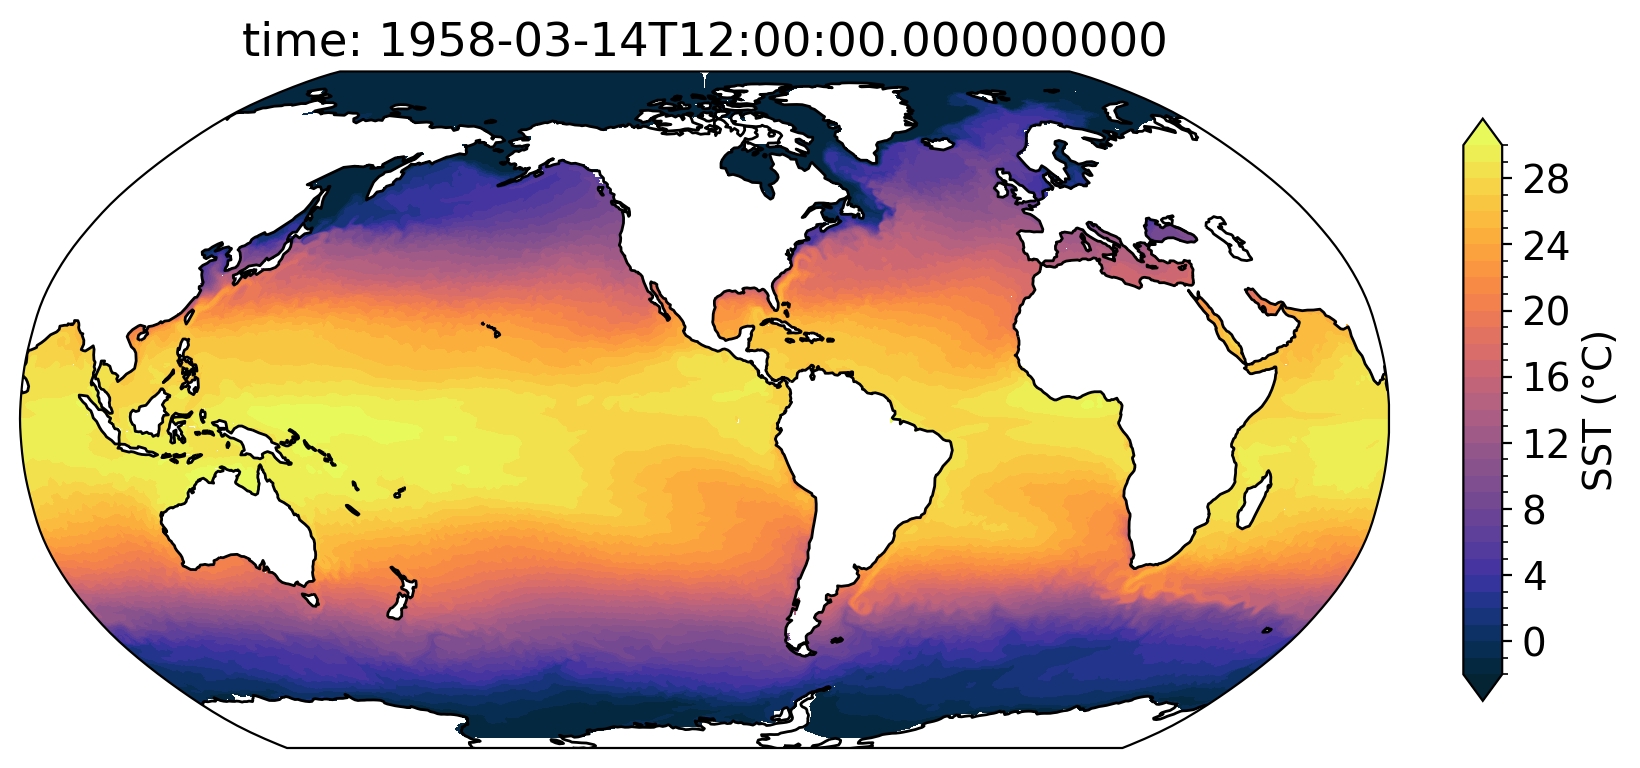

In [8]:
mov.preview(2)

And now make the movie. We can save as `.gif` or `.mp4`.

In [9]:
mov.save('movie_sst.gif', progress=True)

  0%|          | 0/11 [00:00<?, ?it/s]

Movie created at movie_sst.mp4
GIF created at movie_sst.gif


![movie_sst.gif](movie_sst.gif)

In [10]:
client.close()